# Baseline Model Training & Evaluation

Spectrogram code extracted from: https://github.com/vijay033/Noise-Suppression-Auto-Encoder/blob/master/ProcessWav.ipynb

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# TensorFlow Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Cropping2D, ZeroPadding2D
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# Other
import os
import glob
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
from IPython.display import Audio

2024-05-10 01:43:15.739173: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 01:43:15.780488: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Spectrogram Functions

In [2]:
class SpectrogramDataGenerator(keras.utils.Sequence):
    def __init__(self, X_paths, y_paths, batch_size):
        self.X_paths = X_paths
        self.y_paths = y_paths
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X_paths))

    def __len__(self):
        return int(np.ceil(len(self.X_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        X_batch = []
        y_batch = []
        for i in batch_indices:
            X_batch.append(np.load(self.X_paths[i])/255)
            y_batch.append(np.load(self.y_paths[i])/255)
        return np.array(X_batch), np.array(y_batch)

In [3]:
def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

def recoverLinearScale(rgbArray, magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    width = rgbArray.shape[1]
    height = rgbArray.shape[0]
    # print(phaseMax,phaseMin)
    magnitudeVals = rgbArray[:,:,0].astype(float) + rgbArray[:,:,1].astype(float)
    phaseVals = rgbArray[:,:,2].astype(float)
    phaseRange = phaseMax - phaseMin
    magnitudeRange = magnitudeMax - magnitudeMin
    
    for w in range(width):
        for h in range(height):
            phaseVals[h,w] = (phaseVals[h,w] / 255 * phaseRange) + phaseMin
            magnitudeVals[h,w] = weakenAmplifiedMagnitude(magnitudeVals[h,w])
            magnitudeVals[h,w] = (magnitudeVals[h,w] / (255*2) * magnitudeRange) + magnitudeMin
    return magnitudeVals, phaseVals

def recoverSignalFromSpectrogram(numpyarray):
    data = np.array(numpyarray, dtype='uint8')
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
        
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    recovered = np.array(recovered,dtype=np.int16)
    
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    return recovered


# Use these initializations for recovery from spectrogram
FFT_LENGTH = 512
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
phaseMax = 3.141592653589793 
phaseMin = -3.141592653589793
magnitudeMax = 2211683.973249525
magnitudeMin = 0.0
rate = 16000

## Data Loading

In [4]:
# /data/csc6621/24-team-c/dataset/
files_train = sorted(glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_train/*.npy"))
files_train_y = sorted(glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_ytrain/*.npy"))
files_test = sorted(glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_test/*.npy"))
files_test_y = sorted(glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_ytest/*.npy"))

In [5]:
data = SpectrogramDataGenerator(files_train, files_train_y, batch_size=32)

## Autoencoder

In [6]:
K.clear_session()
INPUT_DIM = (257, 62, 3)

In [7]:
def autoencoder_iter1(input_size):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    padded1 = ZeroPadding2D(padding=((0, 0), (0, 1)))(pool1) # Deal with odd dimensions
    
    conv2 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(padded1)
    conv2 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv4 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    conv4 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    
    up2 = Conv2DTranspose(64, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    crop_up2 = Cropping2D(cropping=((0, 0), (0, 2)))(up2)
    pad_up2 = ZeroPadding2D(padding=((1, 0), (0, 0)))(crop_up2) # Deal with odd dimensions
    conv5 = Conv2D(64, 6, activation='relu', padding='same', kernel_initializer='he_normal')(pad_up2)
    conv5 = Conv2D(64, 6, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    # Output
    conv6 = Conv2D(3, 1, activation='sigmoid')(conv5)
    
    model = Model(inputs=inputs, outputs=conv6)
    
    return model

In [8]:
ae = autoencoder_iter1(INPUT_DIM)
# ae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy']) # adam implementation
ae.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['accuracy'])
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 257, 62, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 257, 62, 64)       832       
                                                                 
 conv2d_1 (Conv2D)           (None, 257, 62, 64)       16448     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 31, 64)      0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 128, 32, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 32, 128)      32896 

2024-05-10 01:43:18.511838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13797 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:da:00.0, compute capability: 7.5


In [9]:
reduce_lr = ReduceLROnPlateau(patience=3, monitor='loss', min_delta=0.0003)
history = ae.fit(data,
                 epochs=20, 
                 callbacks=[reduce_lr]
                )

Epoch 1/20


2024-05-10 01:43:19.027517: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-10 01:43:20.346562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901


219/219 [==============================] - 81s 335ms/step - loss: 0.0426 - accuracy: 0.9044 - lr: 0.0010
Epoch 2/20
219/219 [==============================] - 67s 304ms/step - loss: 0.0346 - accuracy: 0.9069 - lr: 0.0010
Epoch 3/20
219/219 [==============================] - 65s 298ms/step - loss: 0.0334 - accuracy: 0.9111 - lr: 0.0010
Epoch 4/20
219/219 [==============================] - 65s 298ms/step - loss: 0.0328 - accuracy: 0.9129 - lr: 0.0010
Epoch 5/20
219/219 [==============================] - 65s 298ms/step - loss: 0.0324 - accuracy: 0.9139 - lr: 0.0010
Epoch 6/20
219/219 [==============================] - 65s 298ms/step - loss: 0.0320 - accuracy: 0.9145 - lr: 0.0010
Epoch 7/20
219/219 [==============================] - 65s 298ms/step - loss: 0.0316 - accuracy: 0.9150 - lr: 0.0010
Epoch 8/20
219/219 [==============================] - 65s 298ms/step - loss: 0.0313 - accuracy: 0.9155 - lr: 0.0010
Epoch 9/20
219/219 [==============================] - 65s 298ms/step - loss: 0.0310

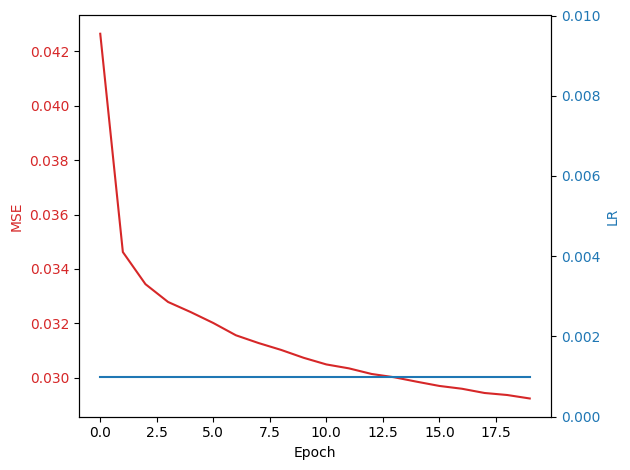

In [10]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE', color=color)
ax1.plot(history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('LR', color=color)
ax2.set_ylim([1e-15, 1e-2])
ax2.plot(history.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
#plt.title('')
plt.show()

In [29]:
#ae.save('basemodel_2.keras')

In [72]:
ae = keras.models.load_model('basemodel_1.keras')

## View Output

In [11]:
test_data = SpectrogramDataGenerator(files_test, files_test_y, batch_size=1)

In [12]:
n = 53
X_test, y_test = test_data[n]
pred = ae.predict(X_test)

1/1 [==============================] - 0s 284ms/step


In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(X_test[0], aspect='auto')
axes[0].set_axis_off()
axes[0].set_title('Noisy')
axes[1].imshow(y_test[0], aspect='auto')
axes[1].set_axis_off()
axes[1].set_title('Clean_true')
axes[2].imshow(pred[0], aspect='auto')
axes[2].set_axis_off()
axes[2].set_title('AE Pred')
plt.show()

In [23]:
noisy_wav = recoverSignalFromSpectrogram(X_test[0] * 255)
clean_wav = recoverSignalFromSpectrogram(y_test[0] * 255)
pred_wav = recoverSignalFromSpectrogram(pred[0] * 255)

In [24]:
Audio(data=noisy_wav, rate=rate)

In [25]:
Audio(data=clean_wav, rate=rate)

In [26]:
Audio(data=pred_wav, rate=rate)

## Test Metrics

In [27]:
def calculate_snr(original_signal, denoised_signal):
    # Calculate signal power
    signal_power = np.mean(original_signal**2)
    # Calculate noise
    noise = original_signal - denoised_signal
    # Calculate noise power
    noise_power = np.mean(noise**2)
    # Calculate SNR in dB
    snr_db = 10 * np.log10(signal_power / noise_power)

    return snr_db

In [28]:
mses = []
maes = []
snrs_input = []
snrs_output = []

test_data = SpectrogramDataGenerator(files_test, files_test_y, batch_size=1)
pred = ae.predict(test_data)
for idx, spectorgram in enumerate(pred):
    noisy_signal = recoverSignalFromSpectrogram(test_data[idx][0][0] * 255).astype('int32')
    true_clean_signal = recoverSignalFromSpectrogram(test_data[idx][1][0] * 255).astype('int32')
    denoised_signal = recoverSignalFromSpectrogram(spectorgram * 255).astype('int32')

    mses.append(mean_squared_error(true_clean_signal, denoised_signal))
    maes.append(mean_absolute_error(true_clean_signal, denoised_signal))
    
    snrs_input.append(calculate_snr(true_clean_signal,noisy_signal))
    snrs_output.append(calculate_snr(true_clean_signal,denoised_signal))

 19/105 [====>.........................] - ETA: 0s

2024-05-10 02:07:41.578117: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


105/105 [==============================] - 1s 6ms/step


In [29]:
better = 0
worse = 0
for i, pair in enumerate(zip(snrs_input, snrs_output)):
    if pair[0] > pair[1]:
        worse +=1
    else:
        better +=1
better, worse

(9, 96)

In [30]:
np.mean(mses), np.mean(maes)

(5587652.889415037, 1301.4742081207485)

## Overall Model Evaluation

In [42]:
model_1 = keras.models.load_model('basemodel_1.keras')
model_2 = keras.models.load_model('basemodel_2.keras')
model_3 = keras.models.load_model('basemodel_3.keras') 

| Model       | MSE            | Epochs | Kernel Size (Encoder) | Kernel Size (Decoder) | Optimizer | SNR   | Comment                             |
|-------------|----------------|--------|-----------------------|-----------------------|-----------|-------|-------------------------------------|
| Base        | 5004875.005    | 20     | [3,3]                 | [3,3]                 | RMSProp   | 14/91 | Produced Blank Spectrograms & Audio |
| Iteration 1 | 5546517.619    | -      | [2,2]                 | [2,2] [6,6]           | -         | 10/95 | N/A                                 |
| Iteration 2 | 5004875.005    | -      | [3,3]                 | [6,6]                 | -         | 14/91 | -                                   |
| Iteration 3 | 5004875.005    | -      | [2,2]                 | [6,6]                 | -         | 14/91 | -                                   |
| Iteration 4 | 5536999.034    | 10     | [2,2]                 | [6,6]                 | -         | 11/94 | N/A                                 |
| Iteration 5 | 5474002.665    | -      | [2,2]                 | [2,2] [6,6]           | Adam      | 11/94 | N/A                                 |
| Iteration 6 | 5247749.930    | -      | [2,2]                 | [3,3] [9,9]           | Adam      | 11/94 | N/A                                 |